### **Tweet Sentiment Analysis - Deep Learning**

Import libaries

In [0]:
import numpy as np
import math
import re 
import pandas as pd
from bs4 import BeautifulSoup

In [0]:
import tensorflow as tf

from tensorflow.keras import layers 
import tensorflow_datasets as tfds

In [0]:
print(tf.__version__)

2.2.0


Loading data & Visualization

In [0]:
#list of column names of our dataset
cols = ["sentiment", "id", "date", "query", "user", "text"]

In [0]:
train_data = pd.read_csv(
    "data2_tweet.csv",
    header=None,
    names=cols,
    skiprows = 1,
    engine="python",
    encoding="latin1"
)

In [0]:
train_data.shape

(10000, 6)

In [0]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1553795194,Sat Apr 18 15:13:59 PDT 2009,NO_QUERY,t_win,It's been the longest day ever! I still haven'...
1,0,2179002334,Mon Jun 15 08:30:28 PDT 2009,NO_QUERY,badsotheynv,I feel uber bad little ol lady is sick wanted ...
2,0,1936039755,Wed May 27 07:20:42 PDT 2009,NO_QUERY,mubi_just_do_it,goose just died...saddest scene i've seen...
3,0,2185132296,Mon Jun 15 16:56:05 PDT 2009,NO_QUERY,walkthistown,@alexamarzi I KNOWW dont move
4,0,2180496762,Mon Jun 15 10:33:02 PDT 2009,NO_QUERY,clare666,@Piewacket1 awwww pie... the 'once in a lifeti...


In [0]:
tweets = train_data['text']
labels = train_data['sentiment']

4    5000
0    5000
Name: sentiment, dtype: int64


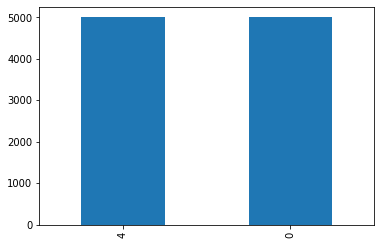

In [0]:
labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())

In [0]:
data = train_data

Data Preporocessing

In [0]:
#The columns important for our text analysis is only the tweet and it's sentiment so We remove all other columns.
data.drop(["id", "date", "query", "user"],
          axis=1,
          inplace=True)

In [0]:
#we have to clean our data because the Tweets may contain punctuations, white spaces, URL links.  upper or lower case... 
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    tweet = re.sub(r" +", ' ', tweet)
    return tweet

In [0]:
data_clean = [clean_tweet(tweet) for tweet in data.text]

In [0]:
data['sentiment'].value_counts()

# 4 :positive sentiment
# 0 :negative sentiment

4    5000
0    5000
Name: sentiment, dtype: int64

In [0]:
#we replace 4 by 1
data_labels = data.sentiment.values
data_labels[data_labels == 4] = 1


In [0]:
data.shape

(10000, 2)

Tokenization

In [0]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**11
)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

Padding

In [0]:
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

Split into: training set - testing set

In [0]:
test_neg_idx = np.random.randint(0, 5000, 500)
test_pos_idx = np.random.randint(5001, 10001, 500)
test_idx = np.concatenate((test_neg_idx, test_pos_idx))

In [0]:
test_inputs = data_inputs[test_idx]
test_labels = data_labels[test_idx]
train_inputs = np.delete(data_inputs, test_idx, axis=0)
train_labels = np.delete(data_labels, test_idx)

Build the  CNN model

In [0]:
class DCNN(tf.keras.Model):
    
    #init function
    def __init__(self,
                 vocab_size,
                 emb_dim=128, 
                 nb_filters=50, 
                 FFN_units=512, 
                 nb_classes=2, 
                 dropout_rate=0.1, 
                 training=False, 
                 name="dcnn"): 
        super(DCNN, self).__init__(name=name)  
        
        #Defining layers
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2, 
                                    padding="valid",  
                                    activation="relu") 
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        
 
        self.pool = layers.GlobalMaxPool1D() 
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")  
        self.dropout = layers.Dropout(rate=dropout_rate) 
        
        
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, 
                                           activation="sigmoid") 
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax") 
    #call function
    def call(self, inputs, training): 
        x = self.embedding(inputs) 
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) 
        merged = self.dense_1(merged) 
        merged = self.dropout(merged, training)
        output = self.last_dense(merged) 
        
        return output

Configuration

In [0]:
##Model parameters
VOCAB_SIZE = tokenizer.vocab_size

EMB_DIM = 200

NB_FILTERS = 100

FFN_UNITS = 256

NB_CLASSES = len(set(train_labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 32

NB_EPOCHS = 5

Training

In [0]:
##Creating an instance of the model and pass all the required parameters as defined before
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [0]:
##Model compilation
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"]) 
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [0]:
#checkpoint
checkpoint_path = "/content/sample_data/"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5) 
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

Latest checkpoint restored!!


In [0]:
#Fitting the model
Dcnn.fit(train_inputs,
         train_labels,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)
ckpt_manager.save()

Epoch 1/5
283/283 [==============================] - 3s 9ms/step - loss: 0.1546 - accuracy: 0.9546
Epoch 2/5
283/283 [==============================] - 2s 8ms/step - loss: 0.0190 - accuracy: 0.9941
Epoch 3/5
283/283 [==============================] - 2s 8ms/step - loss: 0.0028 - accuracy: 0.9990
Epoch 4/5
283/283 [==============================] - 2s 8ms/step - loss: 0.0016 - accuracy: 0.9993
Epoch 5/5
283/283 [==============================] - 2s 8ms/step - loss: 0.0015 - accuracy: 0.9993


'/content/sample_data/ckpt-8'

Evaluation

In [0]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results)


32/32 [==============================] - 0s 3ms/step - loss: 0.1534 - accuracy: 0.9620
[0.15337592363357544, 0.9620000123977661]


In [0]:
Dcnn.metrics_names

['loss', 'accuracy']

Applications/Examples

In [0]:
#Output value very close to zero indicates negative sentiment while close to 1 indicate positive sentiment.

In [0]:
Dcnn(np.array([tokenizer.encode("He is the best")]), training=False).numpy()  #positive sentiment

array([[0.9657709]], dtype=float32)

In [0]:
Dcnn(np.array([tokenizer.encode("Doesn't make sense")]), training=False).numpy()  #negative sentiment


array([[0.00160782]], dtype=float32)

In [0]:
Dcnn(np.array([tokenizer.encode("He sucks at playing")]), training=False).numpy()  #negative sentiment


array([[2.5474297e-12]], dtype=float32)

In [0]:
Dcnn(np.array([tokenizer.encode("You are so funny")]), training=False).numpy()   #positive sentiment


array([[0.98762244]], dtype=float32)